(sec-timetagging)=

# Tutorial: Timetagging

```{seealso}
The complete source code of this tutorial can be found in

{nb-download}`Timetagging.ipynb`
```

## Introduction

```{admonition} Note
The Timetag and TimetagTrace protocols are currently only implemented for the Qblox backend, and they are available on the **QTM**. Please also see {ref}`sec-qblox-acquisition-details` for more information on Qblox module-specific behavior of these operations.
```

The timetag acquisitions return the time at which the input voltage crossed a set threshold. This tutorial explores various ways to perform timetag acquisitions, using a Qblox cluster with a QCM and a QTM module. Note that only a subset of the features of these acquisitions are shown here, see the {ref}`reference guide <sec-acquisition-protocols-timetag>` for more info.

## Initial setup

First, we import the required classes and set up the data directory.

In [1]:
from qblox_instruments import Cluster, ClusterType

from quantify_core.data import handling as dh
from quantify_scheduler import InstrumentCoordinator, QuantumDevice, Schedule, SerialCompiler
from quantify_scheduler.enums import BinMode, TimeRef, TimeSource
from quantify_scheduler.qblox import ClusterComponent
from quantify_scheduler.operations import SquarePulse, Timetag, TimetagTrace, Trace

dh.set_datadir(dh.default_datadir())

Data will be saved in:
/root/quantify-data


Next, we write the {ref}`hardware configuration <sec-tutorial-compiling>`: 

- In the `"hardware_description"` we define a QCM and a QTM module (when using physical hardware, we also connect port 1 of the QCM with port 1 of the QTM).

- In the `"connectivity"` we assign the QCM port 1 (`"cluster0.module{QCM_SLOT}.real_output_0"`) to a mock device port `"qcm:out"`, and assign the QTM port 1 (`"cluster0.module{QTM_SLOT}.digital_output_0"`) to the mock device port `"qtm:in"`.

- In the {ref}`sec-qblox-digitization-thresholds` of `"hardware_options"` we set the value of `in_threshold_primary` field, which is the value of the voltage threshold that needs to be crossed to register a timetag in QTM modules. Note the `"qtm:in-digital"` key that is used here; `digital` is the default clock assigned to digital channels.

In [2]:
QCM_SLOT = 7
QTM_SLOT = 10

hw_cfg = {
    "config_type": "quantify_scheduler.backends.qblox_backend.QbloxHardwareCompilationConfig",
    "hardware_description": {
        "cluster0": {
            "instrument_type": "Cluster",
            "ref": "internal",
            "modules": {
                f"{QCM_SLOT}": {"instrument_type": "QCM"},
                f"{QTM_SLOT}": {"instrument_type": "QTM"},
            },
        },
    },
    "hardware_options": {
        "digitization_thresholds": {"qtm:in-digital": {"in_threshold_primary": 0.5}},
    },
    "connectivity": {
        "graph": [
            [f"cluster0.module{QCM_SLOT}.real_output_0", "qcm:out"],
            [f"cluster0.module{QTM_SLOT}.digital_input_0", "qtm:in"],
        ]
    },
}

We create an {class}`~quantify_scheduler.instrument_coordinator.instrument_coordinator.InstrumentCoordinator` instance with a cluster, where we also provide a `dummy_cfg` dummy configuration so that this notebook can run without physical hardware (when using a real cluster, provide `identifier` instead of `dummy_cfg`).

In [3]:
instrument_coordinator = InstrumentCoordinator(name="ic")
cluster = Cluster(
    name="cluster0",
    # identifier="10.10.10.10",
    dummy_cfg={
        QCM_SLOT: ClusterType.CLUSTER_QCM,
        QTM_SLOT: ClusterType.CLUSTER_QTM,
    },
)

cluster_component = ClusterComponent(cluster)
instrument_coordinator.add_component(cluster_component)

Finally, we define a {class}`~quantify_scheduler.device_under_test.quantum_device.QuantumDevice` (since we do not have a "real" quantum device, this object serves simply to generate the compilation configuration later on).

In [4]:
quantum_device = QuantumDevice(name="quantum_device")
quantum_device.hardware_config(hw_cfg)

## Timetag acquisition

In all examples in this tutorial, except the gate-level example, the QCM will send four pulses with increasing time between the pulses.

In the first example, we'll record a single timetag using the {class}`~quantify_scheduler.operations.acquisition_library.Timetag` acquisition protocol. The event that triggers this timetag is defined by the {class}`time_source <quantify_scheduler.enums.TimeSource>` parameter, which we set to the first detected rising edge (`TimeSource.FIRST`). The timetag represents the time elapsed since the moment specified by the {class}`time_ref <quantify_scheduler.enums.TimeRef>` parameter, which we set to the start of the acquisition (`TimeRef.START`). We will simply do one repetition of the schedule.

```{note}
With the `bin_mode` parameter it is possible to change the behaviour of the acquisition for multiple repetitions. Please see the {ref}`reference guide <sec-acquisition-protocols-timetag>` for more information.
```

In [5]:
sched = Schedule("Timetag")

sched.add(
    Timetag(
        duration=10e-6,
        port="qtm:in",
        clock="digital",
        time_source=TimeSource.FIRST,
        time_ref=TimeRef.START,
    )
)

square_pulse = SquarePulse(amp=1.0, duration=200e-9, port="qcm:out")
sched.add(square_pulse, rel_time=100e-9, ref_pt="start")
for rel_time in (1e-6, 2e-6, 3e-6):
    sched.add(square_pulse, rel_time=rel_time, ref_pt="start")

Let's compile the schedule.

In [6]:
compiler = SerialCompiler(name="compiler")
compiled_schedule = compiler.compile(
    schedule=sched,
    config=quantum_device.generate_compilation_config(),
)

And send it to the hardware, and execute it.

In [ ]:
instrument_coordinator.prepare(compiled_schedule)
instrument_coordinator.start()
instrument_coordinator.wait_done(timeout_sec=10)
acquisition = instrument_coordinator.retrieve_acquisition()

The acquisition data shows one timetag, in this case around 73 ns. This value can differ depending on cable length.

In [7]:
import numpy as np
import xarray as xr

data_array = xr.DataArray(
        np.array([72.97265625]).reshape((1, 1)),
        dims=["repetition", "acq_index_0"],
        coords={"acq_index_0": [0]},
        attrs={"acq_protocol": "Timetag"},
    )
acquisition = xr.Dataset({0: data_array})

In [8]:
acquisition.isel(repetition=0)

<xarray.Dataset> Size: 16B
Dimensions:      (acq_index_0: 1)
Coordinates:
  * acq_index_0  (acq_index_0) int64 8B 0
Data variables:
    0            (acq_index_0) float64 8B 72.97

Next up, we will show you how to record multiple timetags in an acquisition window.

## TimetagTrace acquisition

The {class}`~quantify_scheduler.operations.acquisition_library.TimetagTrace` acquisition can record a stream of timetags. Every time that a rising edge is detected, a timetag is recorded. Therefore, this time we expect to see 4 timetags from the 4 pulses sent by the QCM.

The timetag values are equal to the time difference between the recorded rising edges and the `time_ref` ({class}`~quantify_scheduler.enums.TimeRef`), which we set to the start of the acquisition (`TimeRef.START`).

In [9]:
sched = Schedule("TimetagTrace")

sched.add(
    TimetagTrace(duration=10e-6, port="qtm:in", clock="digital", time_ref=TimeRef.START)
)

square_pulse = SquarePulse(amp=1.0, duration=200e-9, port="qcm:out")
sched.add(square_pulse, rel_time=100e-9, ref_pt="start")
for rel_time in (1e-6, 2e-6, 3e-6):
    sched.add(square_pulse, rel_time=rel_time, ref_pt="start")

We compile the schedule.

In [10]:
compiler = SerialCompiler(name="compiler")
compiled_schedule = compiler.compile(
    schedule=sched,
    config=quantum_device.generate_compilation_config(),
)

And we execute it on the hardware.

In [ ]:
instrument_coordinator.prepare(compiled_schedule)
instrument_coordinator.start()
instrument_coordinator.wait_done(timeout_sec=10)

acquisition = instrument_coordinator.retrieve_acquisition()

As expected, we record 4 timetags. The first one is roughly around the same value as the single timetag recorded above, and the other ones are 1000, 3000, and 6000 ns later, respectively.

In [11]:
import xarray as xr

data_array = xr.DataArray(
        np.array([72.99365234, 1072.96435547, 3072.94970703, 6072.97314453]).reshape((1, 1, 4)),
        dims=["repetition", "acq_index_0", "trace_index_0"],
        coords={"acq_index_0": [0], "trace_index_0": list(range(4))},
        attrs={"acq_protocol": "Timetag"},
    )
acquisition = xr.Dataset({0: data_array})

In [12]:
acquisition.isel(acq_index_0=0, repetition=0)

<xarray.Dataset> Size: 72B
Dimensions:        (trace_index_0: 4)
Coordinates:
    acq_index_0    int64 8B 0
  * trace_index_0  (trace_index_0) int64 32B 0 1 2 3
Data variables:
    0              (trace_index_0) float64 32B 72.99 1.073e+03 ... 6.073e+03

## Trace acquisition

Finally, we can measure a trace of the input signal. The QTM digitizes this signal and will return `0` whenever the voltage is below the digitization threshold, and `1` when the voltage is above. The trace has a 1 ns time resolution.

We use the same schedule again, but with the {class}`~quantify_scheduler.operations.acquisition_library.Trace` protocol. Note the `bin_mode`, which must be set to `BinMode.FIRST` when using `Trace` acquisition on a QTM module.

In [13]:
sched = Schedule("Trace")

sched.add(Trace(duration=10e-6, port="qtm:in", clock="digital", bin_mode=BinMode.FIRST))

square_pulse = SquarePulse(amp=1.0, duration=200e-9, port="qcm:out")
sched.add(square_pulse, rel_time=100e-9, ref_pt="start")
for rel_time in (1e-6, 2e-6, 3e-6):
    sched.add(square_pulse, rel_time=rel_time, ref_pt="start")

We compile the schedule.

In [14]:
compiler = SerialCompiler(name="compiler")
compiled_schedule = compiler.compile(
    schedule=sched,
    config=quantum_device.generate_compilation_config(),
)

And execute it on the hardware again.

In [ ]:
instrument_coordinator.prepare(compiled_schedule)
instrument_coordinator.start()
instrument_coordinator.wait_done(timeout_sec=10)

acquisition = instrument_coordinator.retrieve_acquisition()

The result is a trace of the pulses sent by the QCM, digitized by the QTM.

In [15]:
import xarray as xr

dummy_data = np.zeros((10000,))

dummy_data[140:340] = 1
dummy_data[1140:1340] = 1
dummy_data[3140:3340] = 1
dummy_data[6140:6340] = 1

data_array = xr.DataArray(
        np.array(dummy_data, dtype=int).reshape(1, -1),
        dims=["acq_index_0", "trace_index_0"],
        coords={"acq_index_0": [0], "trace_index_0": list(range(10000))},
        attrs={"acq_protocol": "Timetag"},
    )
acquisition = xr.Dataset({0: data_array})

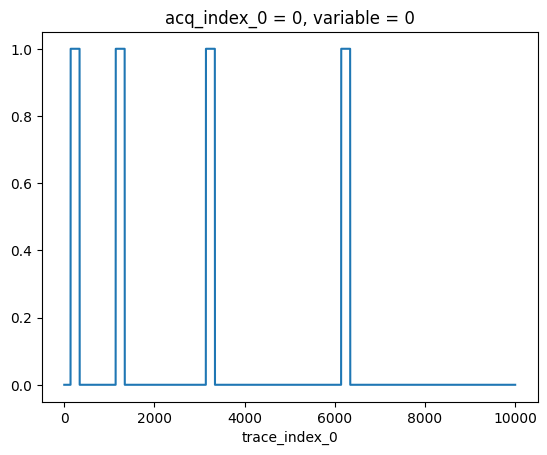

In [16]:
acquisition.to_dataarray().plot()

## Gate-level: NV center example

To finish the tutorial, we show how to use the timetag acquisition protocol with an NV center defined in the quantum device.

To keep the tutorial focused, we only include the readout laser in the hardware configuration (and leave re-ionization and spin-pump lasers out). Again, we use port 1 of the QCM, this time connected to an optical modulator, and port 1 of the QTM, connected to a single-photon detector:

In [17]:
QCM_SLOT = 7
QTM_SLOT = 10

hw_cfg = {
    "config_type": "quantify_scheduler.backends.qblox_backend.QbloxHardwareCompilationConfig",
    "hardware_description": {
        "cluster0": {
            "instrument_type": "Cluster",
            "ref": "internal",
            "modules": {
                f"{QCM_SLOT}": {"instrument_type": "QCM"},
                f"{QTM_SLOT}": {"instrument_type": "QTM"},
            },
        },
        "red_laser": {"instrument_type": "LocalOscillator", "power": 1},
        "optical_mod_red_laser": {"instrument_type": "OpticalModulator"},
    },
    "hardware_options": {
        "modulation_frequencies": {
            "qe0:optical_control-qe0.ge0": {"interm_freq": 0.0, "lo_freq": None},
            "qe0:optical_readout-qe0.ge0": {"interm_freq": 0.0, "lo_freq": None},
        },
        "digitization_thresholds": {
            "qe0:optical_readout-qe0.ge0": {"in_threshold_primary": 0.5}
        },
    },
    "connectivity": {
        "graph": [
            [f"cluster0.module{QCM_SLOT}.real_output_0", "optical_mod_red_laser.if"],
            ["red_laser.output", "optical_mod_red_laser.lo"],
            ["optical_mod_red_laser.out", "qe0:optical_control"],
            [f"cluster0.module{QTM_SLOT}.digital_input_0", "qe0:optical_readout"],
        ]
    },
}

We now add a mock laser to our instrument coordinator so that the example compiles.

In [18]:
from quantify_scheduler import GenericInstrumentCoordinatorComponent, MockLocalOscillator

red_laser = MockLocalOscillator(name="red_laser")
instrument_coordinator.add_component(GenericInstrumentCoordinatorComponent(red_laser))

Then we add a {class}`~quantify_scheduler.device_under_test.nv_element.BasicElectronicNVElement` (our NV center) to the quantum device. Note that measurement parameters such as `time_source` and `time_ref` are now defined on the quantum device element.

In [19]:
from quantify_scheduler import BasicElectronicNVElement

quantum_device.hardware_config(hw_cfg)

qe0 = BasicElectronicNVElement("qe0")
qe0.measure.pulse_amplitude(1.0)
qe0.measure.time_source(TimeSource.FIRST)
qe0.measure.time_ref(TimeRef.START)
qe0.clock_freqs.ge0.set(470.4e12)
quantum_device.add_element(qe0)

The schedule consists simply of a `Measure` operation, which includes a readout pulse (sent from the QCM to the optical modulator) and a timetag acquisition.

In [20]:
from quantify_scheduler.operations import Measure

sched = Schedule("NV Timetag")

sched.add(Measure("qe0", acq_protocol="Timetag", bin_mode=BinMode.APPEND))

{'name': '404974e3-b32f-4077-812c-03c4de418385', 'operation_id': '6135460136591039693', 'timing_constraints': [{'rel_time': 0, 'ref_schedulable': None, 'ref_pt_new': None, 'ref_pt': None}], 'label': '404974e3-b32f-4077-812c-03c4de418385'}

Finally, we compile the schedule and show the pulse and the acquisition operation in a pulse diagram.

In [21]:
compiler = SerialCompiler(name="compiler")
compiled_schedule = compiler.compile(
    schedule=sched,
    config=quantum_device.generate_compilation_config(),
)

compiled_schedule.plot_pulse_diagram(plot_backend="plotly")